In [7]:
import torch

### 3.
Hàm softmax dùng exponential function (e) mà không phải số khác như 2, 3 hoặc 4:
do e là cơ số tự nhiên được sử dụng phổ biến, $e^x$ đạo hàm được và có đạo hàm đẹp hơn các số tự nhiên ($=e^x$)

### 1.
Cho bài toán XOR,

Implement thuật toán neural network để giải bài toán


In [8]:
import torch.nn as nn
from torch.autograd import Variable

In [9]:
# create data
X = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])

y = torch.Tensor([0., 1., 1., 0.]).reshape(X.shape[0], 1)

In [10]:
class XOR(nn.Module):
    def __init__(self):
        super(XOR, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)

    def forward(self, input):
      x = self.linear(input)
      sig = self.Sigmoid(x)
      yh = self.linear2(sig)
      return yh

In [11]:
xor_network = XOR()

In [12]:
epochs = 1000
mseloss = nn.MSELoss()
optimizer = torch.optim.Adam(xor_network.parameters(), lr = 0.03)
all_losses = []
current_loss = 0
plot_every = 50

# train

for epoch in range(epochs):
  yhat = xor_network.forward(X)
  loss = mseloss(yhat, y)

  loss.backward()

  optimizer.step()

  optimizer.zero_grad()

  current_loss += loss
  if epoch % plot_every == 0:
      all_losses.append(current_loss / plot_every)
      current_loss = 0


In [13]:
# show weights and bias
for name, param in xor_network.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[-7.0018,  1.4256],
        [ 7.6912,  4.8053]])
linear.bias tensor([-1.2641, -0.6895])
linear2.weight tensor([[0.9522, 1.0639]])
linear2.bias tensor([-0.5636])


In [14]:
# test input
input = torch.tensor([1., 1.])
out = xor_network(input)
print(out.round())

input = torch.tensor([0., 0.])
out = xor_network(input)
print(out.round())

tensor([1.], grad_fn=<RoundBackward0>)
tensor([0.], grad_fn=<RoundBackward0>)


### 2. Dataset MNIST
- Implement thuật toán neural network với dữ liệu trên sử dụng Pytorch
- Chỉnh learning rate, vẽ đồ thị loss tương ứng.
- Chia tập train/test tỉ lệ 80/20 (MNIST chia sẵn train test?), tính các chỉ số accuracy, recall, f1-score trên tập test.

In [46]:
import torchvision.datasets as datasets
import torchvision

In [47]:
batch_size_train = 64
batch_size_test = 1000

In [48]:
path = '/content/drive/MyDrive/23-24-01-last-semester/deep-learning-in-fault-detection/Data'
mnist_trainset = datasets.MNIST(root=path, train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

mnist_testset = datasets.MNIST(root=path, train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=True)

In [49]:

mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/23-24-01-last-semester/deep-learning-in-fault-detection/Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [50]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [52]:
network = Net()

n_epochs = 3

learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [60]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train.dataset) for i in range(n_epochs + 1)]

In [57]:
def train_f(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train.dataset),
        100. * batch_idx / len(train), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train.dataset)))


In [55]:
def test_f():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test.dataset),
    100. * correct / len(test.dataset)))

In [58]:
test_f()
for epoch in range(1, n_epochs + 1):
  train_f(epoch)
  test_f()

<ipython-input-51-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3293, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.389119
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300278
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.279443
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.249715
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264347
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.220769
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.245453
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.119972
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.059029
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.065121
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.043583
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.911955
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.743253
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.801963
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.534840
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.525995
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.412307
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.361782
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.306677
Train Epoch: 1 [12160

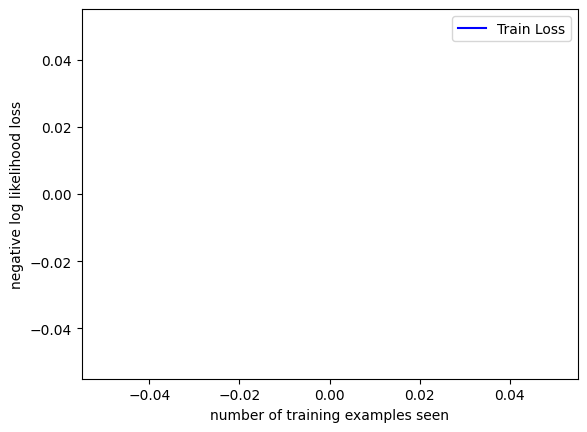

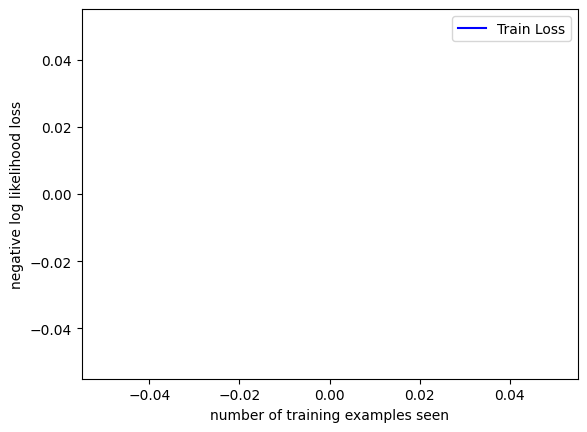

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
